In [1]:
import requests

url = "https://github.com/italojs/facial-landmarks-recognition/raw/master/shape_predictor_68_face_landmarks.dat"
response = requests.get(url)
local_file_path = "shape_predictor_68_face_landmarks.dat"
with open(local_file_path, "wb") as file:
    file.write(response.content)
local_file_path


'shape_predictor_68_face_landmarks.dat'

/var/folders/lz/prnnstss4270b6kkf9y_whw80000gn/T/ipykernel_52529/2451191225.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  hull1_1to2.append(points1[int(hullindex_1to2[i])])
/var/folders/lz/prnnstss4270b6kkf9y_whw80000gn/T/ipykernel_52529/2451191225.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  hull2_1to2.append(points2[int(hullindex_1to2[i])])
/var/folders/lz/prnnstss4270b6kkf9y_whw80000gn/T/ipykernel_52529/2451191225.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprec

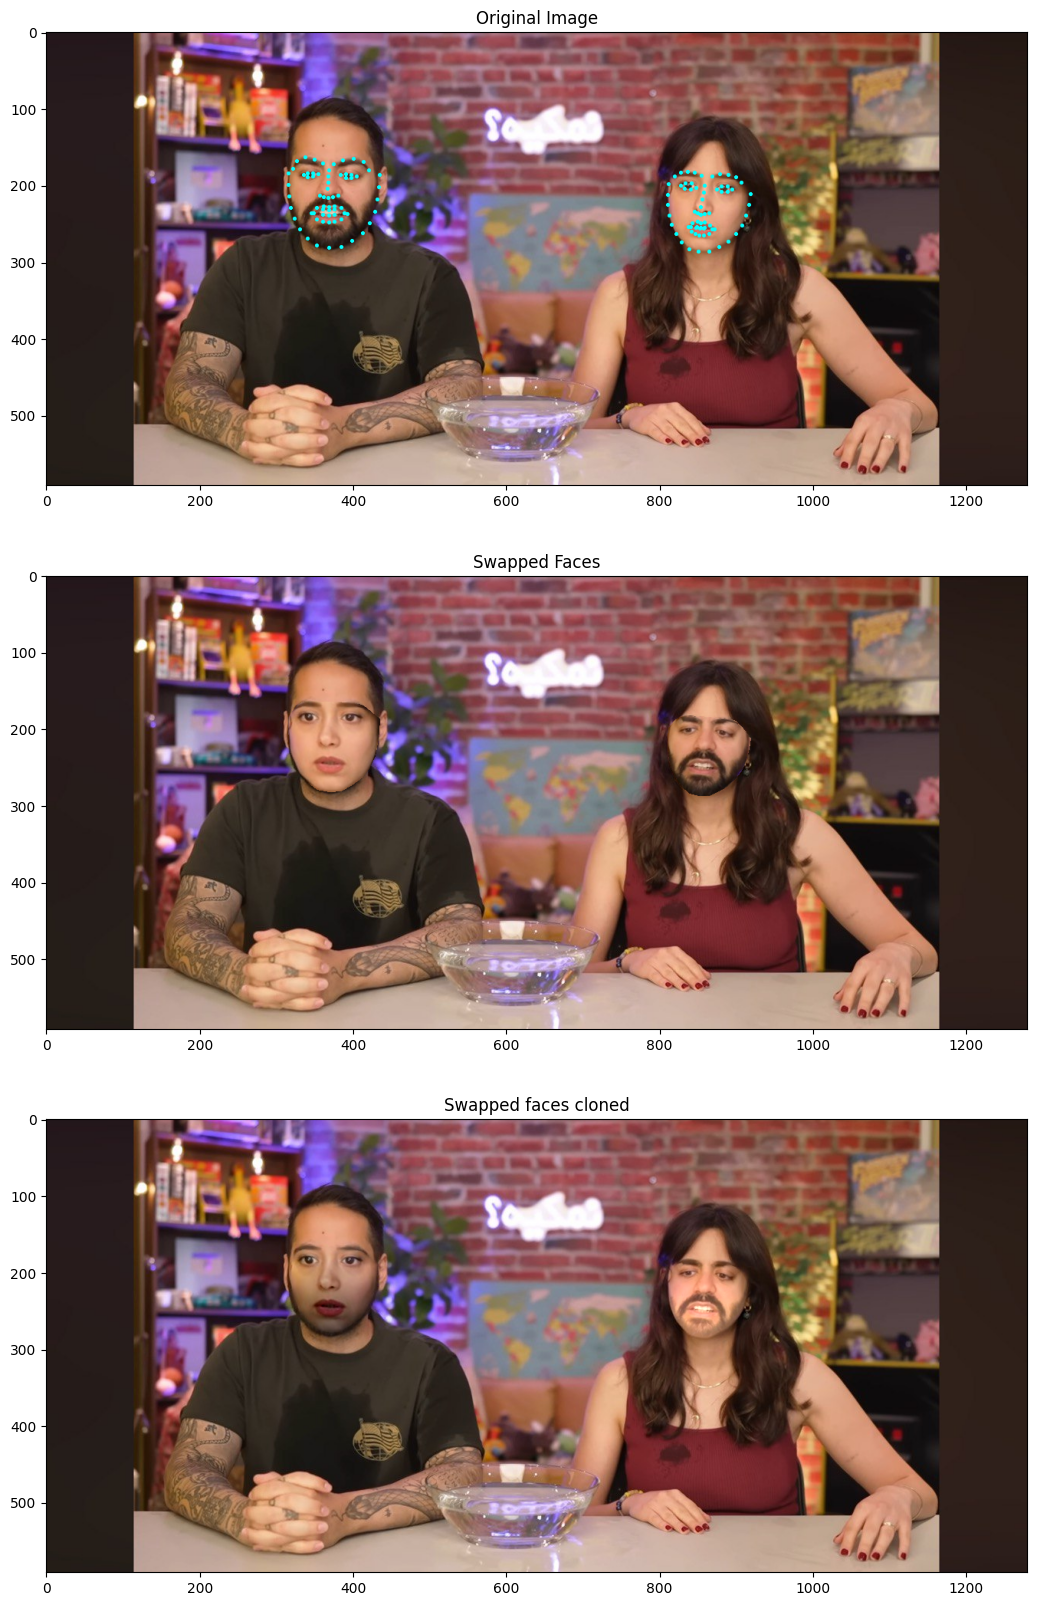

In [3]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import dlib

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(local_file_path)

def get_landmarks(image):
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    faces = detector(gray)
    if len(faces) < 2:
        return []
    all_landmarks = []
    for face in faces:
        landmarks = predictor(gray, face)
        points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(68)]
        all_landmarks.append(points)
    return all_landmarks

image = cv.imread("miakoroush.jpg")
image_copy = image.copy()
imgWarped = np.copy(image)
landmarks = get_landmarks(image)

if len(landmarks) < 2:
    raise Exception("تصویر باید حاوی دو چهره باشد.")

points1 = landmarks[0]
points2 = landmarks[1]

for x, y in points1:
    cv.circle(image_copy, (x, y), 1, (255, 255, 0), 2)
for x, y in points2:
    cv.circle(image_copy, (x, y), 1, (255, 255, 0), 2)


hull1_1to2 = []
hull1_2to1 = []
hull2_1to2 = []
hull2_2to1 = []
hullindex_1to2 = cv.convexHull(np.array(points2),returnPoints=False)
hullindex_2to1 = cv.convexHull(np.array(points1),returnPoints=False)
for i in range(len(hullindex_1to2)):
    hull1_1to2.append(points1[int(hullindex_1to2[i])])
    hull2_1to2.append(points2[int(hullindex_1to2[i])])
for i in range(len(hullindex_2to1)):
    hull1_2to1.append(points1[int(hullindex_2to1[i])])
    hull2_2to1.append(points2[int(hullindex_2to1[i])])
def rectContains(rect, point):
    if point[0] < rect[0]:
        return False
    elif point[1] < rect[1]:
        return False
    elif point[0] > rect[0] + rect[2]:
        return False
    elif point[1] > rect[1] + rect[3]:
        return False
    return True

def calculateDelaunayTriangles(rect, points):
    subdiv = cv.Subdiv2D(rect)
    for p in points:
        subdiv.insert(p)
    triangleList = subdiv.getTriangleList()
    delaunayTri = []
    pt = []
    for t in triangleList:
        pt.append((t[0], t[1]))
        pt.append((t[2], t[3]))
        pt.append((t[4], t[5]))
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])
        if rectContains(rect, pt1) and rectContains(rect, pt2) and rectContains(rect, pt3):
            ind = []
            for j in range(0, 3):
                for k in range(0, len(points)):
                    if abs(pt[j][0] - points[k][0]) < 1.0 and abs(pt[j][1] - points[k][1]) < 1.0:
                        ind.append(k)
            if len(ind) == 3:
                delaunayTri.append((ind[0], ind[1], ind[2]))
        pt = []
    return delaunayTri

rect = (0, 0, image.shape[1], image.shape[0])
dt1 = calculateDelaunayTriangles(rect,hull1_1to2)
dt2 = calculateDelaunayTriangles(rect,hull1_2to1)
def applyAffineTransform(src, srcTri, dstTri, size):
    warpMat = cv.getAffineTransform(np.float32(srcTri), np.float32(dstTri))
    dst = cv.warpAffine(src, warpMat, (size[0], size[1]), None, flags=cv.INTER_LINEAR, borderMode=cv.BORDER_REFLECT_101)
    return dst

def warpTriangle(img1, img2, t1, t2):
    r1 = cv.boundingRect(np.float32([t1]))
    r2 = cv.boundingRect(np.float32([t2]))
    t1Rect = []
    t2Rect = []
    t2RectInt = []
    for i in range(0, 3):
        t1Rect.append(((t1[i][0] - r1[0]), (t1[i][1] - r1[1])))
        t2Rect.append(((t2[i][0] - r2[0]), (t2[i][1] - r2[1])))
        t2RectInt.append(((t2[i][0] - r2[0]), (t2[i][1] - r2[1])))
    mask = np.zeros((r2[3], r2[2], 3), dtype=np.float32)
    cv.fillConvexPoly(mask, np.int32(t2RectInt), (1.0, 1.0, 1.0), 16, 0)
    img1Rect = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]
    size = (r2[2], r2[3])
    img2Rect = applyAffineTransform(img1Rect, t1Rect, t2Rect, size)
    img2Rect = img2Rect * mask
    img2[r2[1]:r2[1] + r2[3], r2[0]:r2[0] + r2[2]] = img2[r2[1]:r2[1] + r2[3], r2[0]:r2[0] + r2[2]] * (1.0 - mask)
    img2[r2[1]:r2[1] + r2[3], r2[0]:r2[0] + r2[2]] = img2[r2[1]:r2[1] + r2[3], r2[0]:r2[0] + r2[2]] + img2Rect

for i in range(len(dt1)):
    t1 = []
    t2 = []
    for j in range(3):
        t1.append(hull1_1to2[dt1[i][j]])
        t2.append(hull2_1to2[dt1[i][j]])
    warpTriangle(image, imgWarped, t1, t2)

for i in range(len(dt2)):
    t1 = []
    t2 = []
    for j in range(3):
        t1.append(hull1_2to1[dt2[i][j]])
        t2.append(hull2_2to1[dt2[i][j]])
    warpTriangle(image, imgWarped, t2, t1)

hull8U_1to2 = []
hull8U_2to1 = []
for i in range(len(hull2_1to2)):
    hull8U_1to2.append((hull2_1to2[i][0], hull2_1to2[i][1]))
for i in range(len(hull1_2to1)):
    hull8U_2to1.append((hull1_2to1[i][0], hull1_2to1[i][1]))

mask = np.zeros(image.shape, dtype=image.dtype)
mask2 = np.zeros(image.shape, dtype=image.dtype)


cv.fillConvexPoly(mask, np.int32(hull8U_1to2), (255, 255, 255))
cv.fillConvexPoly(mask2, np.int32(hull8U_2to1), (255, 255, 255))

r = cv.boundingRect(np.float32([hull2_1to2]))
r2 = cv.boundingRect(np.float32([hull1_2to1]))

center = (r[0] + r[2] // 2, r[1] + r[3] // 2)
center2 = (r2[0] + r2[2] // 2, r2[1] + r2[3] // 2)
output1 = cv.seamlessClone(np.uint8(imgWarped), image, mask, center, cv.NORMAL_CLONE)
output2 = cv.seamlessClone(np.uint8(imgWarped), output1, mask2, center2, cv.NORMAL_CLONE)
plt.figure(figsize=(15,20))
plt.subplot(311); plt.imshow(image_copy[..., ::-1]); plt.title('Original Image');
plt.subplot(312); plt.imshow(imgWarped[..., ::-1]); plt.title('Swapped Faces');
plt.subplot(313); plt.imshow(output2[..., ::-1]); plt.title('Swapped faces cloned');

plt.show()
